<a href="https://colab.research.google.com/github/Emily-KD/DS200/blob/main/chpt_15_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datascience import *
import matplotlib
path_data = 'http://personal.psu.edu/drh20/200DS/assets/data/'
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

/usr/local/lib/python3.7/dist-packages/datascience/tables.py:17: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.7/dist-packages/datascience/util.py:10: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


In [ ]:
import math

#15. Prediction

An important aspect of data science is to find out what data can tell us about the future. What do data about climate and pollution say about temperatures a few decades from now? Based on a person's internet profile, which websites are likely to interest them? How can a patient's medical history be used to judge how well he or she will respond to a treatment?

To answer such questions, data scientists have developed methods for making *predictions*. In this chapter we will study one of the most commonly used ways of predicting the value of one variable based on the value of another.

Here is a historical dataset used for the prediction of the heights of adults based on the heights of their parents. We have studied this dataset in an earlier section. The table `heights` contains data on the midparent height and child's height (all in inches) for a population of 934 adult "children". Recall that the midparent height is an average of the heights of the two parents.

In [ ]:
# Data on heights of parents and their adult children
original = Table.read_table(path_data + 'family_heights.csv')
heights = Table().with_columns(
    'MidParent', original.column('midparentHeight'),
    'Child', original.column('childHeight')
    )

In [ ]:
heights

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69
75.43,69
73.66,73.5
73.66,72.5
73.66,65.5
73.66,65.5
72.06,71
72.06,68


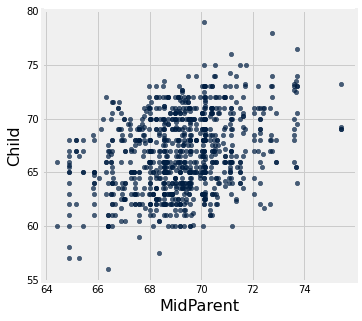

In [ ]:
heights.scatter('MidParent')

A primary reason for studying the data was to be able to predict the adult height of a child born to parents who were similar to those in the dataset. We made these predictions in Section 8.1, after noticing the positive association between the two variables. 

Our approach was to base the prediction on all the points that correspond to a midparent height of around the midparent height of the new person. To do this, we wrote a function called `predict_child` which takes a midparent height as its argument and returns the average height of all the children who had midparent heights within half an inch of the argument.

In [ ]:
def predict_child(mpht):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of mpht.
    
    The prediction is the average height of the children 
    whose midparent height is in the range mpht plus or minus 0.5 inches.
    """
    
    close_points = heights.where('MidParent', are.between(mpht-0.5, mpht + 0.5))
    return close_points.column('Child').mean()                       

We applied the function to the column of `Midparent` heights, and visualized the result.

In [ ]:
# Apply predict_child to all the midparent heights

heights_with_predictions = heights.with_column(
    'Prediction', heights.apply(predict_child, 'MidParent')
    )

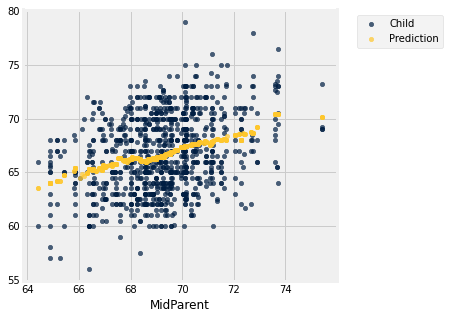

In [ ]:
# Draw the original scatter plot along with the predicted values

heights_with_predictions.scatter('MidParent')

The prediction at a given midparent height lies roughly at the center of the vertical strip of points at the given height. This method of prediction is called *regression.* Later in this chapter we will see whether we can avoid our arbitrary definitions of "closeness" being "within 0.5 inches". But first we will develop a measure that can be used in many settings to decide how good one variable will be as a predictor of another.

##15.1. Correlation

In this section we will develop a measure of how tightly clustered a scatter diagram is about a straight line. Formally, this is called measuring *linear association*.

In [ ]:
def r_scatter(r):
    plots.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.scatter(x, y)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)

The table `hybrid` contains data on hybrid passenger cars sold in the United States from 1997 to 2013. The data were adapted from the online data archive of [Prof. Larry Winner](http://www.stat.ufl.edu/%7Ewinner/) of the University of Florida. The columns:

- `vehicle`: model of the car
- `year`: year of manufacture
- `msrp`: manufacturer's suggested retail price in 2013 dollars
- `acceleration`: acceleration rate in km per hour per second
- `mpg`: fuel econonmy in miles per gallon
- `class`: the model's class.

In [ ]:
hybrid = Table.read_table(path_data + 'hybrid.csv')

In [ ]:
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


The graph below is a scatter plot of `msrp` *versus* `acceleration`. That means `msrp` is plotted on the vertical axis and `accelaration` on the horizontal.

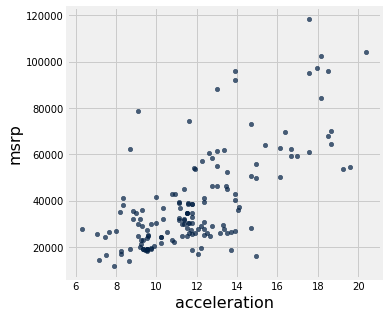

In [ ]:
hybrid.scatter('acceleration', 'msrp')

Notice the positive association. The scatter of points is sloping upwards, indicating that cars with greater acceleration tended to cost more, on average; conversely, the cars that cost more tended to have greater acceleration on average. 

The scatter diagram of MSRP versus mileage shows a negative association. Hybrid cars with higher mileage tended to cost less, on average. This seems surprising till you consider that cars that accelerate fast tend to be less fuel efficient and have lower mileage. As the previous scatter plot showed, those were also the cars that tended to cost more. 

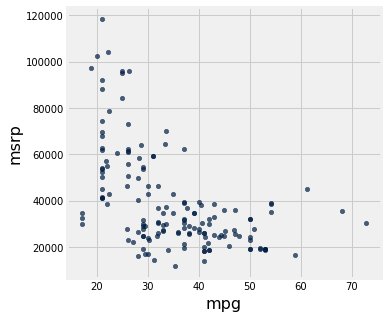

In [ ]:
hybrid.scatter('mpg', 'msrp')

Along with the negative association, the scatter diagram of price versus efficiency shows a non-linear relation between the two variables. The points appear to be clustered around a curve, not around a straight line. 

If we restrict the data just to the SUV class, however, the association between price and efficiency is still negative but the relation appears to be more linear. The relation between the price and acceleration of SUV's also shows a linear trend, but with a positive slope.

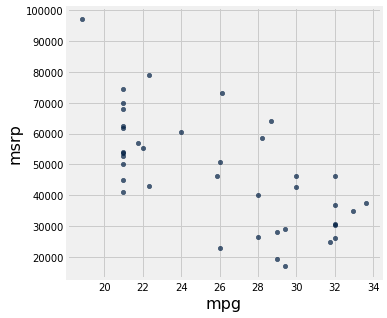

In [ ]:
suv = hybrid.where('class', 'SUV')
suv.scatter('mpg', 'msrp')

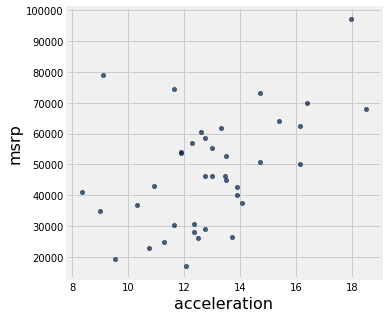

In [ ]:
suv.scatter('acceleration', 'msrp')

You will have noticed that we can derive useful information from the general orientation and shape of a scatter diagram even without paying attention to the units in which the variables were measured.

Indeed, we could plot all the variables in standard units and the plots would look the same. This gives us a way to compare the degree of linearity in two scatter diagrams.

Recall that in an earlier section we defined the function `standard_units` to convert an array of numbers to standard units.

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

We can use this function to re-draw the two scatter diagrams for SUVs, with all the variables measured in standard units.

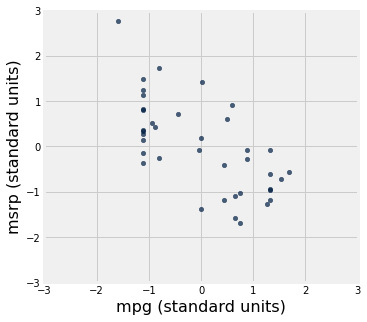

In [ ]:
Table().with_columns(
    'mpg (standard units)',  standard_units(suv.column('mpg')), 
    'msrp (standard units)', standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

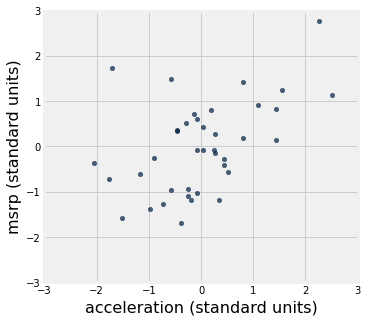

In [ ]:
Table().with_columns(
    'acceleration (standard units)', standard_units(suv.column('acceleration')), 
    'msrp (standard units)',         standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

The associations that we see in these figures are the same as those we saw before. Also, because the two scatter diagrams are now drawn on exactly the same scale, we can see that the linear relation in the second diagram is a little more fuzzy than in the first.

We will now define a measure that uses standard units to quantify the kinds of association that we have seen.

###15.1.1. The correlation coefficient

The *correlation coefficient* measures the strength of the linear relationship between two variables. Graphically, it measures how clustered the scatter diagram is around a straight line.

The term *correlation coefficient* isn't easy to say, so it is usually shortened to *correlation* and denoted by $r$.

Here are some mathematical facts about $r$ that we will just observe by simulation.

- The correlation coefficient $r$ is a number between $-1$ and 1.
- $r$ measures the extent to which the scatter plot clusters around a straight line.
- $r = 1$ if the scatter diagram is a perfect straight line sloping upwards, and $r = -1$ if the scatter diagram is a perfect straight line sloping downwards.

The function ``r_scatter`` takes a value of $r$ as its argument and simulates a scatter plot with a correlation very close to $r$. Because of randomness in the simulation, the correlation is not expected to be exactly equal to $r$.

Call ``r_scatter`` a few times, with different values of $r$ as the argument, and see how the scatter plot changes. 

When $r=1$ the scatter plot is perfectly linear and slopes upward. When $r=-1$, the scatter plot is perfectly linear and slopes downward. When $r=0$, the scatter plot is a formless cloud around the horizontal axis, and the variables are said to be *uncorrelated*.

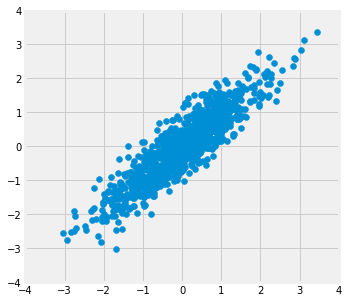

In [ ]:
r_scatter(0.9)

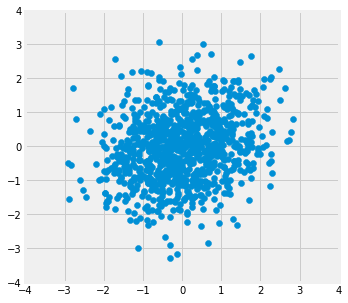

In [ ]:
r_scatter(0.25)

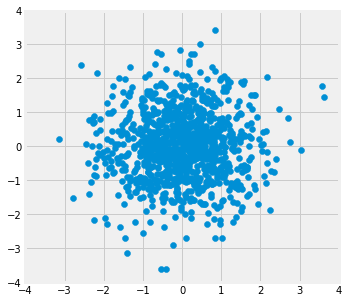

In [ ]:
r_scatter(0)

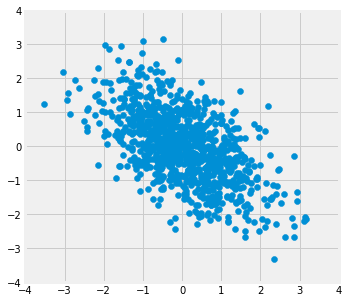

In [ ]:
r_scatter(-0.55)

###15.1.2. Calculating $r$

The formula for $r$ is not apparent from our observations so far. It has a mathematical basis that is outside the scope of this class. However, as you will see, the calculation is straightforward and helps us understand several of the properties of $r$.

**Formula for $r$**:

**$r$ is the average of the products of the two variables, when both variables are measured in standard units.**

Here are the steps in the calculation. We will apply the steps to a simple table of values of $x$ and $y$.

In [ ]:
x = np.arange(1, 7, 1)
y = make_array(2, 3, 1, 5, 2, 7)
t = Table().with_columns(
        'x', x,
        'y', y
    )
t

x,y
1,2
2,3
3,1
4,5
5,2
6,7


Based on the scatter diagram, we expect that $r$ will be positive but not equal to 1.

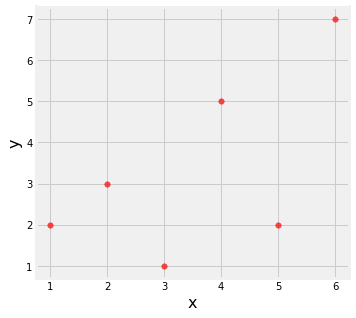

In [ ]:
t.scatter(0, 1, s=30, color='red')

**Step 1.** Convert each variable to standard units.

In [ ]:
t_su = t.with_columns(
        'x (standard units)', standard_units(x),
        'y (standard units)', standard_units(y)
    )
t_su

x,y,x (standard units),y (standard units)
1,2,-1.46385,-0.648886
2,3,-0.87831,-0.162221
3,1,-0.29277,-1.13555
4,5,0.29277,0.811107
5,2,0.87831,-0.648886
6,7,1.46385,1.78444


**Step 2.** Multiply each pair of standard units.

In [ ]:
t_product = t_su.with_column('product of standard units', t_su.column(2) * t_su.column(3))
t_product

x,y,x (standard units),y (standard units),product of standard units
1,2,-1.46385,-0.648886,0.949871
2,3,-0.87831,-0.162221,0.142481
3,1,-0.29277,-1.13555,0.332455
4,5,0.29277,0.811107,0.237468
5,2,0.87831,-0.648886,-0.569923
6,7,1.46385,1.78444,2.61215


**Step 3.** $r$ is the average of the products computed in Step 2.

In [ ]:
# r is the average of the products of standard units

r = np.mean(t_product.column(4))
r

0.6174163971897709

As expected, $r$ is positive but not equal to 1.

###15.1.3. Properties of $r$

The calculation shows that:

- $r$ is a pure number. It has no units. This is because $r$ is based on standard units.
- $r$ is unaffected by changing the units on either axis. This too is because $r$ is based on standard units.
- $r$ is unaffected by switching the axes. Algebraically, this is because the product of standard units does not depend on which variable is called $x$ and which $y$. Geometrically, switching axes reflects the scatter plot about the line $y=x$, but does not change the amount of clustering nor the sign of the association.

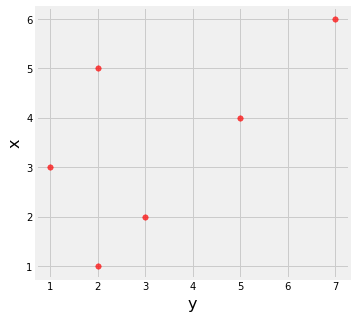

In [ ]:
t.scatter('y', 'x', s=30, color='red')

###15.1.4. The `correlation` function
We are going to be calculating correlations repeatedly, so it will help to define a function that computes it by performing all the steps described above. Let's define a function ``correlation`` that takes a table and the labels of two columns in the table. The function returns $r$, the mean of the products of those column values in standard units.

In [ ]:
def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

Let's call the function on the ``x`` and ``y`` columns of ``t``. The function returns the same answer to the correlation between $x$ and $y$ as we got by direct application of the formula for $r$. 

In [ ]:
correlation(t, 'x', 'y')

0.6174163971897709

As we noticed, the order in which the variables are specified doesn't matter.

In [ ]:
correlation(t, 'y', 'x')

0.6174163971897709

Calling ``correlation`` on columns of the table ``suv`` gives us the correlation between price and mileage as well as the correlation between price and acceleration.

In [ ]:
correlation(suv, 'mpg', 'msrp')

-0.6667143635709919

In [ ]:
correlation(suv, 'acceleration', 'msrp')

0.48699799279959155

These values confirm what we had observed: 

- There is a negative association between price and efficiency, whereas the association between price and acceleration is positive.
- The linear relation between price and acceleration is a little weaker (correlation about 0.5) than between price and mileage (correlation about -0.67). 

Correlation is a simple and powerful concept, but it is sometimes misused. Before using $r$, it is important to be aware of what correlation does and does not measure.

###15.1.5. Association is not Causation

Correlation only measures association. Correlation does not imply causation. Though the correlation between the weight and the math ability of children in a school district may be positive, that does not mean that doing math makes children heavier or that putting on weight improves the children's math skills. Age is a confounding variable: older children are both heavier and better at math than younger children, on average.

###15.1.6. Correlation Measures *Linear* Association
Correlation measures only one kind of association – linear. Variables that have strong non-linear association might have very low correlation. Here is an example of variables that have a perfect quadratic relation $y = x^2$ but have correlation equal to 0.

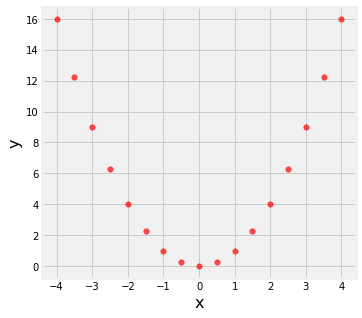

In [ ]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')

In [ ]:
correlation(nonlinear, 'x', 'y')

0.0

####RMSE

In [ ]:
def shotput_quadratic_rmse(a, b, c):
    x = nonlinear.column('x')
    y = nonlinear.column('y')
    fitted = a*(x**2) + b*x + c
    return math.sqrt(np.mean((y - fitted) ** 2))
#mean of the square of the differences

In [ ]:
best_nonlinear = minimize(shotput_quadratic_mse)
best_nonlinear

NameError: ignored

In [ ]:
shotput_quadratic_mse(best_nonlinear.item(0), best_nonlinear.item(1), best_nonlinear.item(2))

###15.1.7. Correlation is Affected by Outliers
Outliers can have a big effect on correlation. Here is an example where a scatter plot for which $r$ is equal to 1 is turned into a plot for which $r$ is equal to 0, by the addition of just one outlying point.

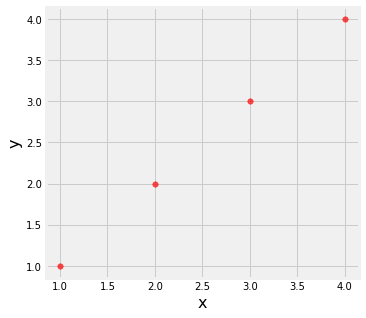

In [ ]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y', s=30, color='r')

In [ ]:
correlation(line, 'x', 'y')

1.0

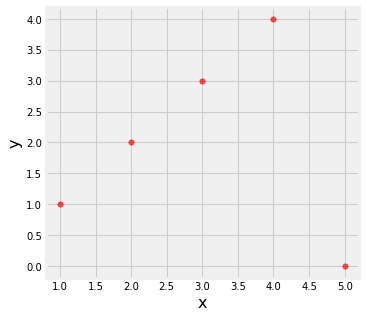

In [ ]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y', s=30, color='r')

In [ ]:
correlation(outlier, 'x', 'y')

0.0

###15.1.8. Ecological Correlations Should be Interpreted with Care
Correlations based on aggregated data can be misleading. As an example, here are data on the Critical Reading and Math SAT scores in 2014. There is one point for each of the 50 states and one for Washington, D.C. The column ``Participation Rate`` contains the percent of high school seniors who took the test. The next three columns show the average score in the state on each portion of the test, and the final column is the average of the total scores on the test.

In [ ]:
sat2014 = Table.read_table(path_data + 'sat2014.csv').sort('State')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
Alabama,6.7,547,538,532,1617
Alaska,54.2,507,503,475,1485
Arizona,36.4,522,525,500,1547
Arkansas,4.2,573,571,554,1698
California,60.3,498,510,496,1504
Colorado,14.3,582,586,567,1735
Connecticut,88.4,507,510,508,1525
Delaware,100,456,459,444,1359
District of Columbia,100,440,438,431,1309
Florida,72.2,491,485,472,1448


The scatter diagram of Math scores versus Critical Reading scores is very tightly clustered around a straight line; the correlation is close to 0.985. 

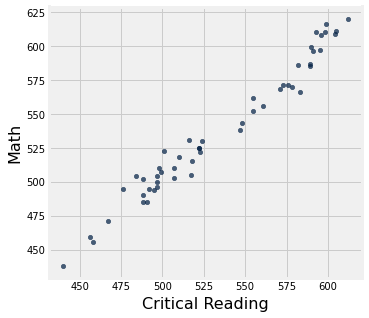

In [ ]:
sat2014.scatter('Critical Reading', 'Math')
#this is a mean of students, 

In [ ]:
correlation(sat2014, 'Critical Reading', 'Math')

0.9847558411067434

That's an extremely high correlation. But it's important to note that this does not reflect the strength of the relation between the Math and Critical Reading scores of *students*. 

The data consist of average scores in each state. But states don't take tests – students do. The data in the table have been created by lumping all the students in each state into a single point at the average values of the two variables in that state. But not all students in the state will be at that point, as students vary in their performance. If you plot a point for each student instead of just one for each state, there will be a cloud of points around each point in the figure above. The overall picture will be more fuzzy. The correlation between the Math and Critical Reading scores of the students will be *lower* than the value calculated based on state averages.

Correlations based on aggregates and averages are called *ecological correlations* and are frequently reported. As we have just seen, they must be interpreted with care.

###15.1.9. Serious or tongue-in-cheek?

In 2012, a [paper](http://www.biostat.jhsph.edu/courses/bio621/misc/Chocolate%20consumption%20cognitive%20function%20and%20nobel%20laurates%20%28NEJM%29.pdf) in the respected New England Journal of Medicine examined the relation between chocolate consumption and Nobel Prizes in a group of countries. The [Scientific American](http://blogs.scientificamerican.com/the-curious-wavefunction/chocolate-consumption-and-nobel-prizes-a-bizarre-juxtaposition-if-there-ever-was-one/) responded seriously whereas
[others](http://www.reuters.com/article/2012/10/10/us-eat-chocolate-win-the-nobel-prize-idUSBRE8991MS20121010#vFdfFkbPVlilSjsB.97) were more relaxed. You are welcome to make your own decision! The following graph, provided in the paper, should motivate you to go and take a look.

In [ ]:
from IPython.display import Image
Image("../../../images/chocoNobel.png")

##15.2. The Regression Line
The correlation coefficient $r$ doesn't just measure how clustered the points in a scatter plot are about a straight line. It also helps identify the straight line about which the points are clustered. In this section we will retrace the path that Galton and Pearson took to discover that line.

As we have seen, our dataset on the heights of parents and their adult children indicates a linear association between the two variables. The linearity was confirmed when our predictions of the children's heights based on the midparent heights roughly followed a straight line.

In [ ]:
original = Table.read_table(path_data + 'family_heights.csv')

heights = Table().with_columns(
    'MidParent', original.column('midparentHeight'),
    'Child', original.column('childHeight')
    )

In [ ]:
def predict_child(mpht):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of mpht.
    
    The prediction is the average height of the children 
    whose midparent height is in the range mpht plus or minus 0.5 inches.
    """
    
    close_points = heights.where('MidParent', are.between(mpht-0.5, mpht + 0.5))
    return close_points.column('Child').mean()   

In [ ]:
heights_with_predictions = heights.with_column(
    'Prediction', heights.apply(predict_child, 'MidParent')
    )

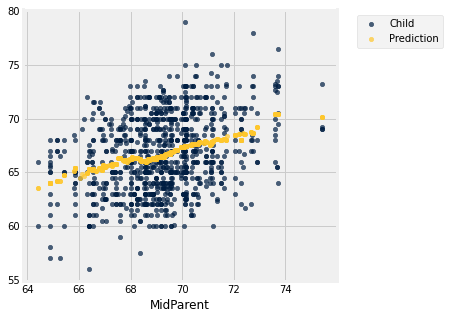

In [ ]:
heights_with_predictions.scatter('MidParent')

###15.2.1. Measuring in Standard Units

Let's see if we can find a way to identify this line. First, notice that linear association doesn't depend on the units of measurement – we might as well measure both variables in standard units. 

In [ ]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz))/np.std(xyz)  

In [ ]:
heights_SU = Table().with_columns(
    'MidParent SU', standard_units(heights.column('MidParent')),
    'Child SU', standard_units(heights.column('Child'))
)
heights_SU

MidParent SU,Child SU
3.45465,1.80416
3.45465,0.686005
3.45465,0.630097
3.45465,0.630097
2.47209,1.88802
2.47209,1.60848
2.47209,-0.348285
2.47209,-0.348285
1.58389,1.18917
1.58389,0.350559


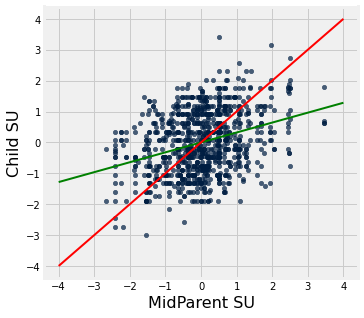

In [ ]:
#Assignment 
heights_SU.scatter(0, 1)
plots.plot([-4, 4], [-4*0.32094989606395935,4*0.32094989606395935], color='g', lw=2)
plots.plot([-4,4],[-4 * 1, 4 * 1], color='r', lw=2)

In [ ]:
correlation(heights_SU, 'MidParent SU', 'Child SU')

0.32094989606395935

On this scale, we can calculate our predictions exactly as before. But first we have to figure out how to convert our old definition of "close" points to a value on the new scale. We had said that midparent heights were "close" if they were within 0.5 inches of each other. Since standard units measure distances in units of SDs, we have to figure out how many SDs of midparent height correspond to 0.5 inches.

One SD of midparent heights is about 1.8 inches. So 0.5 inches is about 0.28 SDs.

In [ ]:
sd_midparent = np.std(heights.column(0))
sd_midparent

1.8014050969207571

In [ ]:
0.5/sd_midparent

0.277561110965367

 We are now ready to modify our prediction function to make predictions on the standard units scale. All that has changed is that we are using the table of values in standard units, and defining "close" as above.

In [ ]:
def predict_child_su(mpht_su):
    """Return a prediction of the height (in standard units) of a child 
    whose parents have a midparent height of mpht_su in standard units.
    """
    close = 0.5/sd_midparent
    close_points = heights_SU.where('MidParent SU', are.between(mpht_su-close, mpht_su + close))
    return close_points.column('Child SU').mean()   

In [ ]:
heights_with_su_predictions = heights_SU.with_column(
    'Prediction SU', heights_SU.apply(predict_child_su, 'MidParent SU')
    )

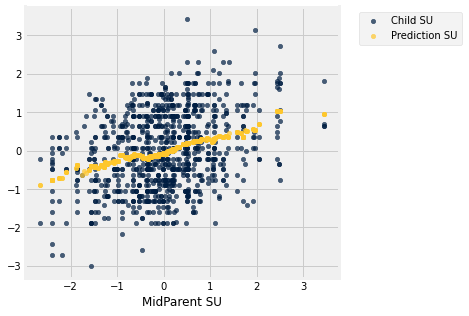

In [ ]:
heights_with_su_predictions.scatter('MidParent SU')

This plot looks exactly like the plot drawn on the original scale. Only the numbers on the axes have changed. This confirms that we can understand the prediction process by just working in standard units.

###15.2.2. Identifying the Line in Standard Units
The scatter plot above has a *football* shape – that is, it is roughly oval like an American football. Not all scatter plots are football shaped, not even those that show linear association. But in this section we will work only with football shaped scatter plots. In the next section, we will generalize our analysis to other shapes of plots.

Here is a football shaped scatter plot with both variables measured in standard units. The 45 degree line is shown in red.

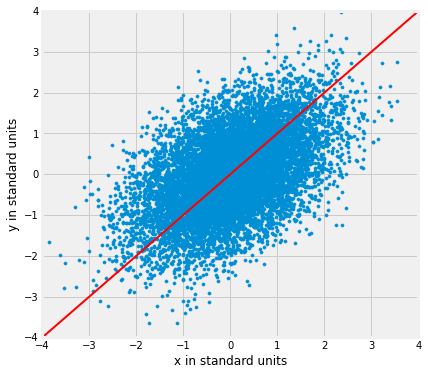

In [ ]:
r = 0.5
x_demo = np.random.normal(0, 1, 10000)
z_demo = np.random.normal(0, 1, 10000)
y_demo = r*x_demo + np.sqrt(1 - r**2)*z_demo
plots.figure(figsize=(6,6))
plots.xlim(-4, 4)
plots.ylim(-4, 4)
plots.scatter(x_demo, y_demo, s=10)
#plots.plot([-4, 4], [-4*0.6,4*0.6], color='g', lw=2)
plots.plot([-4,4],[-4,4], color='r', lw=2)
#plots.plot([1.5,1.5], [-4,4], color='k', lw=2)
plots.xlabel('x in standard units')
plots.ylabel('y in standard units');

But the 45 degree line is not the line that picks off the centers of the vertical strips. You can see that in the figure below, where the vertical line at 1.5 standard units is shown in black. The points on the scatter plot near the black line all have heights roughly in the -2 to 3 range. The red line is too high to pick off the center.

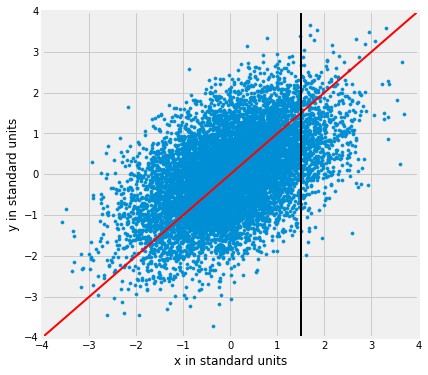

In [ ]:
r = 0.5
x_demo = np.random.normal(0, 1, 10000)
z_demo = np.random.normal(0, 1, 10000)
y_demo = r*x_demo + np.sqrt(1 - r**2)*z_demo
plots.figure(figsize=(6,6))
plots.xlim(-4, 4)
plots.ylim(-4, 4)
plots.scatter(x_demo, y_demo, s=10)
#plots.plot([-4, 4], [-4*0.6,4*0.6], color='g', lw=2)
plots.plot([-4,4],[-4,4], color='r', lw=2)
plots.plot([1.5,1.5], [-4,4], color='k', lw=2)
plots.xlabel('x in standard units')
plots.ylabel('y in standard units');

So the 45 degree line is not the "graph of averages." That line is the green one shown below.

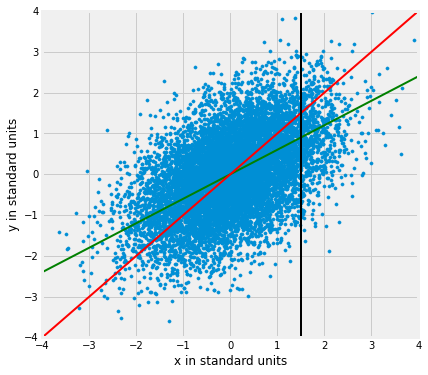

In [ ]:
r = 0.5
x_demo = np.random.normal(0, 1, 10000)
z_demo = np.random.normal(0, 1, 10000)
y_demo = r*x_demo + np.sqrt(1 - r**2)*z_demo
plots.figure(figsize=(6,6))
plots.xlim(-4, 4)
plots.ylim(-4, 4)
plots.scatter(x_demo, y_demo, s=10)
plots.plot([-4, 4], [-4*0.6,4*0.6], color='g', lw=2)
plots.plot([-4,4],[-4,4], color='r', lw=2)
plots.plot([1.5,1.5], [-4,4], color='k', lw=2)
plots.xlabel('x in standard units')
plots.ylabel('y in standard units');

Both lines go through the origin (0, 0). The green line goes through the centers of the vertical strips (at least roughly), and is *flatter* than the red 45 degree line. 

The slope of the 45 degree line is 1. So the slope of the green "graph of averages" line is a value that is positive but less than 1. 

What value could that be? You've guessed it – it's $r$.

###15.2.3. The Regression Line, in Standard Units
The green "graph of averages" line is called the *regression line*, for a reason that we will explain shortly. But first, let's simulate some football shaped scatter plots with different values of $r$, and see how the line changes. In each case, the red 45 degree line has been drawn for comparison.

The function that performs the simulation is called `regression_line` and takes $r$ as its argument.

In [ ]:

def regression_line(r):
    x = np.random.normal(0, 1, 10000)
    z = np.random.normal(0, 1, 10000)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.figure(figsize=(6, 6))
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    plots.scatter(x, y)
    plots.plot([-4, 4], [-4*r,4*r], color='g', lw=2)
    if r >= 0:
        plots.plot([-4,4],[-4,4], lw=2, color='r')
    else:
        plots.plot([-4,4], [4,-4], lw=2, color='r')

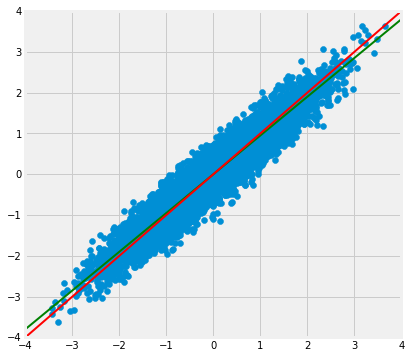

In [ ]:
regression_line(0.95)

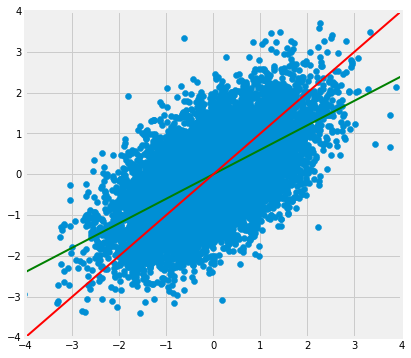

In [ ]:
regression_line(0.6)

When $r$ is close to 1, the scatter plot, the 45 degree line, and the regression line are all very close to each other. But for more moderate values of $r$, the regression line is noticeably flatter.

###15.2.4. The Regression Effect
In terms of prediction, this means that for a parents whose midparent height is at 1.5 standard units, our prediction of the child's height is somewhat *less* than 1.5 standard units. If the midparent height is 2 standard units, we predict that the child's height will be somewhat less than 2 standard units.

In other words, we predict that the child will be somewhat closer to average than the parents were. This is called "regression to the mean" and it is how the name *regression* arises.

Regression to the mean also works when the midparent height is below average. Children whose midparent heights were below average turned out to be somewhat taller relative to their generation, on average. 

In general, individuals who are away from average on one variable are expected to be not quite as far away from average on the other. This is called the *regression effect*.

Keep in mind that the regression effect is a statement about averages. For example, it says that if you take all children whose midparent height is 1.5 standard units, then the average height of these children is somewhat less than 1.5 standard units. It doesn't say that all of these children will be somewhat less than 1.5 standard units in height. Some will be taller, and some will be shorter. The *average* of these heights will be less than 1.5 standard units.

###15.2.5. The Equation of the Regression Line
In regression, we use the value of one variable (which we will call $x$) to predict the value of another (which we will call $y$). When the variables $x$ and $y$ are measured in standard units, the regression line for predicting $y$ based on $x$ has slope $r$ and passes through the origin. Thus the equation of the regression line can be written as:

$$
\mbox{estimate of }y ~=~ r \cdot x ~~~
\mbox{when both variables are measured in standard units}
$$

In the original units of the data, this becomes

$$
\frac{\mbox{estimate of}~y ~-~\mbox{average of}~y}{\mbox{SD of}~y}
~=~ r \times 
\frac{\mbox{the given}~x ~-~\mbox{average of}~x}{\mbox{SD of}~x}
$$


![regline](../../../images/regline.png)

The slope and intercept of the regression line in original units can be derived from the diagram above. 

$$
\mathbf{\mbox{slope of the regression line}} ~=~ r \cdot
\frac{\mbox{SD of }y}{\mbox{SD of }x}
$$

$$
\mathbf{\mbox{intercept of the regression line}} ~=~
\mbox{average of }y ~-~ \mbox{slope} \cdot \mbox{average of }x
$$

The three functions below compute the correlation, slope, and intercept. All of them take three arguments: the name of the table, the label of the column containing $x$, and the label of the column containing $y$.

In [ ]:
def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

###15.2.6. The Regression Line in the Units of the Data
The correlation between midparent height and child's height is 0.32:

In [ ]:
family_r = correlation(heights, 'MidParent', 'Child')
family_r

0.32094989606395924

We can also find the equation of the regression line for predicting the child's height based on midparent height.

In [ ]:
family_slope = slope(heights, 'MidParent', 'Child')
family_intercept = intercept(heights, 'MidParent', 'Child')
family_slope, family_intercept

(0.637360896969479, 22.63624054958975)

The equation of the regression line is

$$
\mbox{estimate of child's height} ~=~ 0.64 \cdot \mbox{midparent height} ~+~ 22.64
$$

This is also known as the *regression equation.* The principal use of the regression equation is to predict $y$ based on $x$.

For example, for a midparent height of 70.48 inches, the regression equation predicts the child's height to be 67.56 inches.

In [ ]:
family_slope * 70.48 + family_intercept

67.55743656799862

Our original prediction, created by taking the average height of all children who had midparent heights close to 70.48, came out to be pretty close: 67.63 inches compared to the regression line's prediction of 67.55 inches.

In [ ]:
heights_with_predictions.where('MidParent', are.equal_to(70.48)).show(3)

MidParent,Child,Prediction
70.48,74,67.6342
70.48,70,67.6342
70.48,68,67.6342


Here are all of the rows of the table, along with our original predictions and the new regression predictions of the children's heights.

In [ ]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression Prediction', family_slope * heights.column('MidParent') + family_intercept
)
heights_with_predictions

MidParent,Child,Prediction,Regression Prediction
75.43,73.2,70.1,70.7124
75.43,69.2,70.1,70.7124
75.43,69,70.1,70.7124
75.43,69,70.1,70.7124
73.66,73.5,70.4158,69.5842
73.66,72.5,70.4158,69.5842
73.66,65.5,70.4158,69.5842
73.66,65.5,70.4158,69.5842
72.06,71,68.5025,68.5645
72.06,68,68.5025,68.5645


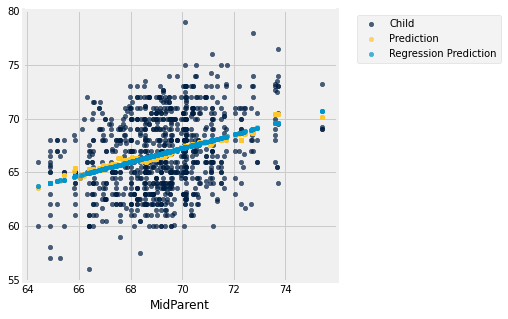

In [ ]:
heights_with_predictions.scatter('MidParent')

The grey dots show the regression predictions, all on the regression line. Notice how the line is very close to the gold graph of averages. For these data, the regression line does a good job of approximating the centers of the vertical strips.

###15.2.7. Fitted Values
The predictions all lie on the line and are known as the "fitted values". The function `fit` takes the name of the table and the labels of $x$ and $y$, and returns an array of fitted values, one fitted value for each point in the scatter plot.

In [ ]:
def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

It is easier to see the line in the graph below than in the one above.

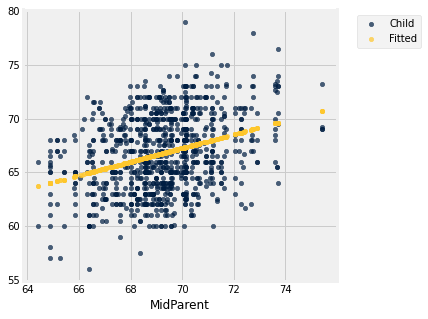

In [ ]:
heights.with_column('Fitted', fit(heights, 'MidParent', 'Child')).scatter('MidParent')

Another way to draw the line is to use the option `fit_line=True` with the Table method `scatter`.

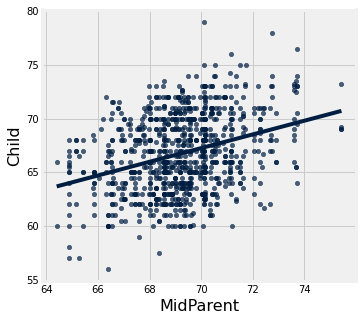

In [ ]:
heights.scatter('MidParent', fit_line=True)

###15.2.8. Units of Measurement of the Slope
The slope is a ratio, and it worth taking a moment to study the units in which it is measured. Our example comes from the familiar dataset about mothers who gave birth in a hospital system. The scatter plot of pregnancy weights versus heights looks like a football that has been used in one game too many, but it's close enough to a football that we can justify putting our fitted line through it. In later sections we will see how to make such justifications more formal.

In [ ]:
baby = Table.read_table(path_data + 'baby.csv')

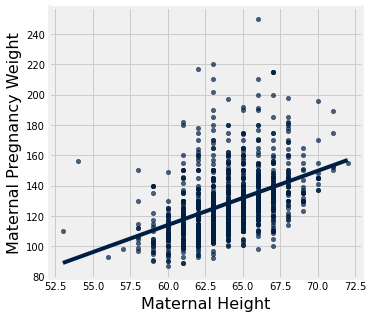

In [ ]:
baby.scatter('Maternal Height', 'Maternal Pregnancy Weight', fit_line=True)

In [ ]:
slope(baby, 'Maternal Height', 'Maternal Pregnancy Weight')

3.572846259275056

The slope of the regression line is **3.57 pounds per inch**. This means that for two women who are 1 inch apart in height, our prediction of pregnancy weight will differ by 3.57 pounds. For a woman who is 2 inches taller than another, our prediction of pregnancy weight will be

$$
2 \times 3.57 ~=~ 7.14
$$

pounds more than our prediction for the shorter woman.

Notice that the successive vertical strips in the scatter plot are one inch apart, because the heights have been rounded to the nearest inch. Another way to think about the slope is to take any two consecutive strips (which are necessarily 1 inch apart), corresponding to two groups of women who are separated by 1 inch in height. The slope of 3.57 pounds per inch means that the average pregnancy weight of the taller group is about 3.57 pounds more than that of the shorter group.

###15.2.9. Example

Suppose that our goal is to use regression to estimate the height of a basset hound based on its weight, using a sample that looks consistent with the regression model. Suppose the observed correlation $r$ is 0.5, and that the summary statistics for the two variables are as in the table below: 

|       |**average**    |**SD**     |   
|------:|:-------------:|:---------:|
|height |14 inches      |2 inches   |
|weight |50 pounds      |5 pounds   |

To calculate the equation of the regression line, we need the slope and the intercept.

$$
\mbox{slope} ~=~ \frac{r \cdot \mbox{SD of }y}{\mbox{SD of }x} ~=~
\frac{0.5 \cdot 2 \mbox{ inches}}{5 \mbox{ pounds}} ~=~ 0.2 ~\mbox{inches per pound}
$$


$$
\mbox{intercept} ~=~ \mbox{average of }y - \mbox{slope}\cdot \mbox{average of } x
~=~ 14 \mbox{ inches} ~-~ 0.2 \mbox{ inches per pound} \cdot 50 \mbox{ pounds}
~=~ 4 \mbox{ inches}
$$

The equation of the regression line allows us to calculate the estimated height, in inches,
based on a given weight in pounds:

$$
\mbox{estimated height} ~=~ 0.2 \cdot \mbox{given weight} ~+~ 4
$$

The slope of the line is measures the increase in the estimated height per unit increase in weight. The slope is positive, and it is important to note that this does not mean that we think basset hounds get taller if they put on weight. The slope reflects the difference in the average heights of two groups of dogs that are 1 pound apart in weight. Specifically, consider a group of dogs whose weight is $w$ pounds, and the group whose weight is $w+1$ pounds. The second group is estimated to be 0.2 inches taller, on average. This is true for all values of $w$ in the sample.

In general, the slope of the regression line can be interpreted as the average increase in $y$ per unit increase in $x$. Note that if the slope is negative, then for every unit increase in $x$, the average of $y$ decreases.

###15.2.10. Endnote
Even though we won't establish the mathematical basis for the regression equation, we can see that it gives pretty good predictions when the scatter plot is football shaped. It is a surprising mathematical fact that no matter what the shape of the scatter plot, the same equation gives the "best" among all straight lines. That's the topic of the next section.

##15.3. The Method of Least Squares
We have developed the equation of the regression line that runs through a football shaped scatter plot. But not all scatter plots are football shaped, not even linear ones. Does every scatter plot have a "best" line that goes through it? If so, can we still use the formulas for the slope and intercept developed in the previous section, or do we need new ones?

To address these questions, we need a reasonable definition of "best". Recall that the purpose of the line is to *predict* or *estimate* values of $y$, given values of $x$. Estimates typically aren't perfect. Each one is off the true value by an *error*. A reasonable criterion for a line to be the "best" is for it to have the smallest possible overall error among all straight lines.

In this section we will make this criterion precise and see if we can identify the best straight line under the criterion.

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

Our first example is a dataset that has one row for every chapter of the novel "Little Women." The goal is to estimate the number of characters (that is, letters, spaces punctuation marks, and so on) based on the number of periods. Recall that we attempted to do this in the very first lecture of this course.

In [ ]:
little_women = Table.read_table(path_data + 'little_women.csv')
little_women = little_women.move_to_start('Periods')
little_women.show(3)

Periods,Characters
189,21759
188,22148
231,20558


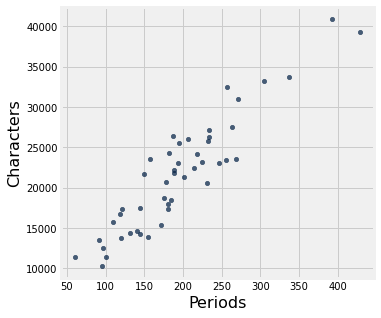

In [ ]:
little_women.scatter('Periods', 'Characters')

To explore the data, we will need to use the functions `correlation`, `slope`, `intercept`, and `fit` defined in the previous section.

In [ ]:
correlation(little_women, 'Periods', 'Characters')

0.9229576895854816

The scatter plot is remarkably close to linear, and the correlation is more than 0.92.

###15.3.1. Error in Estimation

The graph below shows the scatter plot and line that we developed in the previous section. We don't yet know if that's the best among all lines. We first have to say precisely what "best" means.

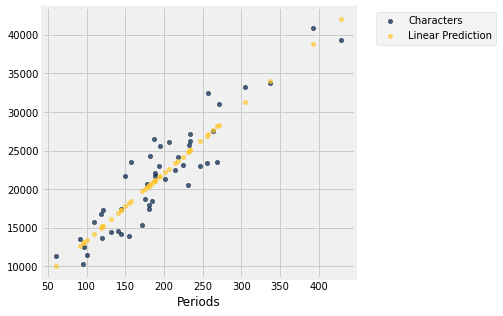

In [ ]:
lw_with_predictions = little_women.with_column('Linear Prediction', fit(little_women, 'Periods', 'Characters'))
lw_with_predictions.scatter('Periods')

Corresponding to each point on the scatter plot, there is an error of prediction calculated as the actual value minus the predicted value. It is the vertical distance between the point and the line, with a negative sign if the point is below the line.

In [ ]:
actual = lw_with_predictions.column('Characters')
predicted = lw_with_predictions.column('Linear Prediction')
errors = actual - predicted

In [ ]:
lw_with_predictions.with_column('Error', errors)

Periods,Characters,Linear Prediction,Error
189,21759,21183.6,575.403
188,22148,21096.6,1051.38
231,20558,24836.7,-4278.67
195,25526,21705.5,3820.54
255,23395,26924.1,-3529.13
140,14622,16921.7,-2299.68
131,14431,16138.9,-1707.88
214,22476,23358,-882.043
337,33767,34056.3,-289.317
185,18508,20835.7,-2327.69


We can use `slope` and `intercept` to calculate the slope and intercept of the fitted line. The graph below shows the line (in light blue). The errors corresponding to four of the points are shown in red. There is nothing special about those four points. They were just chosen for clarity of the display. The function `lw_errors` takes a slope and an intercept (in that order) as its arguments and draws the figure. 

In [ ]:
lw_reg_slope = slope(little_women, 'Periods', 'Characters')
lw_reg_intercept = intercept(little_women, 'Periods', 'Characters')

In [ ]:
sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
def lw_errors(slope, intercept):
    little_women.scatter('Periods', 'Characters')
    xlims = np.array([50, 450])
    plots.plot(xlims, slope * xlims + intercept, lw=2)
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=2)

Slope of Regression Line:     87.0 characters per period
Intercept of Regression Line: 4745.0 characters


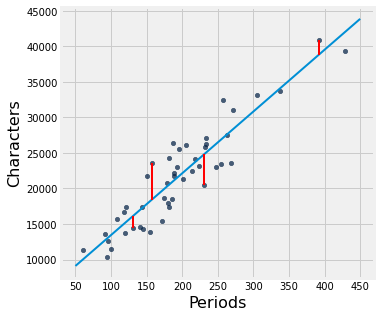

In [ ]:
print('Slope of Regression Line:    ', np.round(lw_reg_slope), 'characters per period')
print('Intercept of Regression Line:', np.round(lw_reg_intercept), 'characters')
lw_errors(lw_reg_slope, lw_reg_intercept)

Had we used a different line to create our estimates, the errors would have been different. The graph below shows how big the errors would be if we were to use another line for estimation. The second graph shows large errors obtained by using a line that is downright silly.

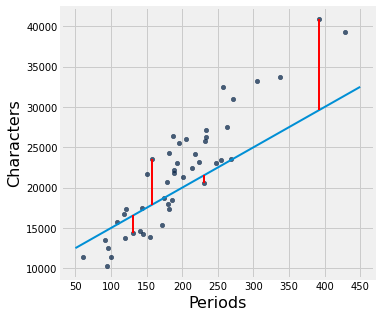

In [ ]:
lw_errors(50, 10000)

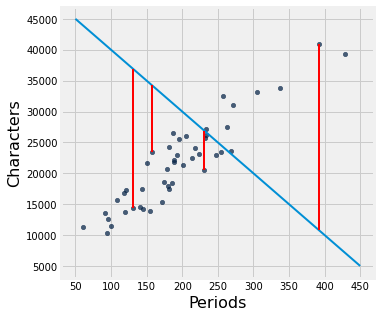

In [ ]:
lw_errors(-100, 50000)

###15.3.2. Root Mean Squared Error

What we need now is one overall measure of the rough size of the errors. You will recognize the approach to creating this – it's exactly the way we developed the SD.

If you use any arbitrary line to calculate your estimates, then some of your errors are likely to be positive and others negative. To avoid cancellation when measuring the rough size of the errors, we will take the mean of the squared errors rather than the mean of the errors themselves. 

The mean squared error of estimation is a measure of roughly how big the squared errors are, but as we have noted earlier, its units are hard to interpret. Taking the square root yields the root mean square error (rmse), which is in the same units as the variable being predicted and therefore much easier to understand. 

###15.3.3. Minimizing the Root Mean Squared Error

Our observations so far can be summarized as follows.

- To get estimates of $y$ based on $x$, you can use any line you want.
- Every line has a root mean squared error of estimation.
- "Better" lines have smaller errors.

Is there a "best" line? That is, is there a line that minimizes the root mean squared error among all lines? 

To answer this question, we will start by defining a function `lw_rmse` to compute the root mean squared error of any line through the Little Women scatter diagram. The function takes the slope and the intercept (in that order) as its arguments.

In [ ]:
def lw_rmse(slope, intercept):
    lw_errors(slope, intercept)
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = slope * x + intercept
    mse = np.mean((y - fitted) ** 2)
    print("Root mean squared error:", mse ** 0.5)

Root mean squared error: 4322.167831766537


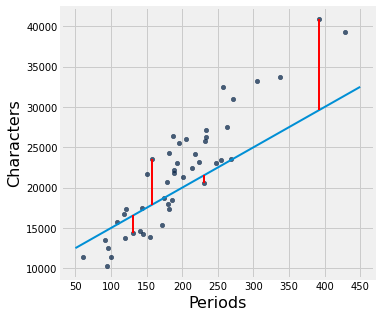

In [ ]:
lw_rmse(50, 10000)

Root mean squared error: 16710.11983735375


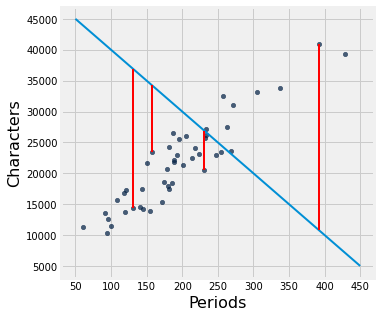

In [ ]:
lw_rmse(-100, 50000)

Bad lines have big values of rmse, as expected. But the rmse is much smaller if we choose a slope and intercept close to those of the regression line.

Root mean squared error: 2715.5391063834586


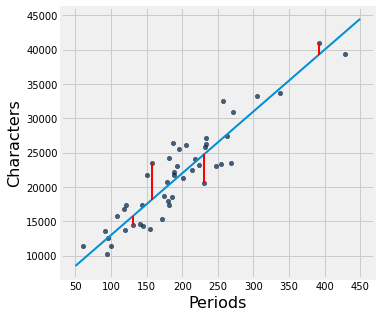

In [ ]:
lw_rmse(90, 4000)

Here is the root mean squared error corresponding to the regression line. By a remarkable fact of mathematics, no other line can beat this one. 

- **The regression line is the unique straight line that minimizes the mean squared error of estimation among all straight lines.**

Root mean squared error: 2701.690785311856


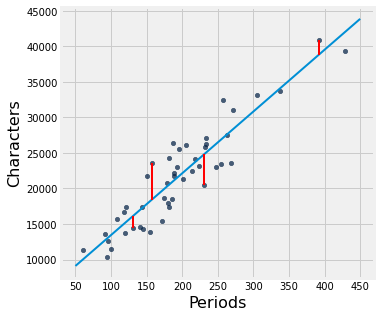

In [ ]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

The proof of this statement requires abstract mathematics that is beyond the scope of this course. On the other hand, we do have a powerful tool – Python – that performs large numerical computations with ease. So we can use Python to confirm that the regression line minimizes the mean squared error.

####15.3.3.1. Numerical Optimization ###
First note that a line that minimizes the root mean squared error is also a line that minimizes the squared error. The square root makes no difference to the minimization. So we will save ourselves a step of computation and just minimize the mean squared error (mse).

We are trying to predict the number of characters ($y$) based on the number of periods ($x$) in chapters of Little Women. If we use the line

$$
\mbox{prediction} ~=~ ax + b
$$

it will have an mse that depends on the slope $a$ and the intercept $b$. The function `lw_mse` takes the slope and intercept as its arguments and returns the corresponding mse.

In [ ]:
def lw_mse(any_slope, any_intercept):
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

Let's check that `lw_mse` gets the right answer for the root mean squared error of the regression line. Remember that `lw_mse` returns the mean squared error, so we have to take the square root to get the rmse.

In [ ]:
lw_mse(lw_reg_slope, lw_reg_intercept)**0.5

2701.690785311856

That's the same as the value we got by using `lw_rmse` earlier:

Root mean squared error: 2701.690785311856


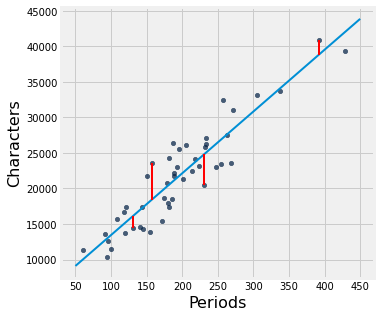

In [ ]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

You can confirm that `lw_mse` returns the correct value for other slopes and intercepts too. For example, here is the rmse of the extremely bad line that we tried earlier.

In [ ]:
lw_mse(-100, 50000)**0.5

16710.11983735375

And here is the rmse for a line that is close to the regression line.

In [ ]:
lw_mse(90, 4000)**0.5

2715.5391063834586

If we experiment with different values, we can find a low-error slope and intercept through trial and error, but that would take a while. Fortunately, there is a Python function that does all the trial and error for us.

The `minimize` function can be used to find the arguments of a function for which the function returns its minimum value. Python uses a similar trial-and-error approach, following the changes that lead to incrementally lower output values. 

The argument of `minimize` is a function that itself takes numerical arguments and returns a numerical value. For example, the function `lw_mse` takes a numerical slope and intercept as its arguments and returns the corresponding mse. 

The call `minimize(lw_mse)` returns an array consisting of the slope and the intercept that minimize the mse. These minimizing values are excellent approximations arrived at by intelligent trial-and-error, not exact values based on formulas.

In [ ]:
best = minimize(lw_mse)
best

array([  86.97784117, 4744.78484535])

These values are the same as the values we calculated earlier by using the `slope` and `intercept` functions. We see small deviations due to the inexact nature of `minimize`, but the values are essentially the same.

In [ ]:
print("slope from formula:        ", lw_reg_slope)
print("slope from minimize:       ", best.item(0))
print("intercept from formula:    ", lw_reg_intercept)
print("intercept from minimize:   ", best.item(1))

slope from formula:         86.97784125829821
slope from minimize:        86.97784116615884
intercept from formula:     4744.784796574928
intercept from minimize:    4744.784845352655


###15.3.4. The Least Squares Line

Therefore, we have found not only that the regression line minimizes mean squared error, but also that minimizing mean squared error gives us the regression line. The regression line is the only line that minimizes mean squared error.

That is why the regression line is sometimes called the "least squares line."

##15.4. Least Squares Regression
In an earlier section, we developed formulas for the slope and intercept of the regression line through a *football shaped* scatter diagram. It turns out that the slope and intercept of the least squares line have the same formulas as those we developed, *regardless of the shape of the scatter plot*.

We saw this in the example about Little Women, but let's confirm it in an example where the scatter plot clearly isn't football shaped. For the data, we are once again indebted to the rich [data archive of Prof. Larry Winner](http://www.stat.ufl.edu/~winner/datasets.html) of the University of Florida. A [2013 study](http://digitalcommons.wku.edu/ijes/vol6/iss2/10/) in the International Journal of Exercise Science studied collegiate shot put athletes and examined the relation between strength and shot put distance. The population consists of 28 female collegiate athletes. Strength was measured by the the biggest amount (in kilograms) that the athlete lifted in the "1RM power clean" in the pre-season. The distance (in meters) was the athlete's personal best.

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

In [ ]:
shotput = Table.read_table(path_data + 'shotput.csv')

In [ ]:
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


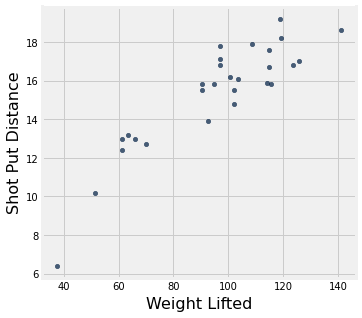

In [ ]:
shotput.scatter('Weight Lifted')

That's not a football shaped scatter plot. In fact, it seems to have a slight non-linear component. But if we insist on using a straight line to make our predictions, there is still one best straight line among all straight lines.

Our formulas for the slope and intercept of the regression line, derived for football shaped scatter plots, give the following values.

In [ ]:
slope(shotput, 'Weight Lifted', 'Shot Put Distance')

0.09834382159781997

In [ ]:
intercept(shotput, 'Weight Lifted', 'Shot Put Distance')

5.959629098373952

Does it still make sense to use these formulas even though the scatter plot isn't football shaped? We can answer this by finding the slope and intercept of the line that minimizes the mse.

We will define the function `shotput_linear_mse` to take an arbirtary slope and intercept as arguments and return the corresponding mse. Then `minimize` applied to `shotput_linear_mse` will return the best slope and intercept.

In [ ]:
def shotput_linear_mse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

In [ ]:
minimize(shotput_linear_mse)

array([0.09834382, 5.95962911])

These values are the same as those we got by using our formulas. To summarize:

**No matter what the shape of the scatter plot, there is a unique line that minimizes the mean squared error of estimation. It is called the regression line, and its slope and intercept are given by**

$$
\mathbf{\mbox{slope of the regression line}} ~=~ r \cdot
\frac{\mbox{SD of }y}{\mbox{SD of }x}
$$

$$
\mathbf{\mbox{intercept of the regression line}} ~=~
\mbox{average of }y ~-~ \mbox{slope} \cdot \mbox{average of }x
$$

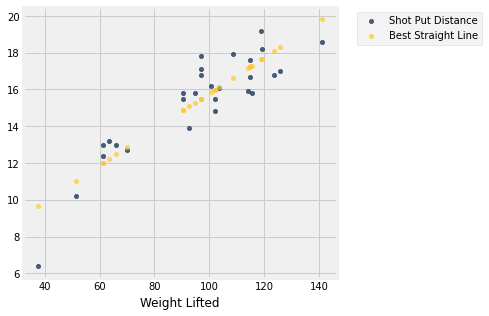

In [ ]:
fitted = fit(shotput, 'Weight Lifted', 'Shot Put Distance')
shotput.with_column('Best Straight Line', fitted).scatter('Weight Lifted')

###15.4.1. Nonlinear Regression
The graph above reinforces our earlier observation that the scatter plot is a bit curved. So it is better to fit a curve than a straight line. The [study](http://digitalcommons.wku.edu/ijes/vol6/iss2/10/) postulated a quadratic relation between the weight lifted and the shot put distance. So let's use quadratic functions as our predictors and see if we can find the best one. 

We have to find the best quadratic function among all quadratic functions, instead of the best straight line among all straight lines. The method of least squares allows us to do this.

The mathematics of this minimization is complicated and not easy to see just by examining the scatter plot. But numerical minimization is just as easy as it was with linear predictors! We can get the best quadratic predictor by once again using `minimize`. Let's see how this works.

Recall that a quadratic function has the form

$$
f(x) ~=~ ax^2 + bx + c
$$

for constants $a$, $b$, and $c$.

To find the best quadratic function to predict distance based on weight lifted, using the criterion of least squares, we will first write a function that takes the three constants as its arguments, calculates the fitted values by using the quadratic function above, and then returns the mean squared error. 

The function is called `shotput_quadratic_mse`. Notice that the definition is analogous to that of `lw_mse`, except that the fitted values are based on a quadratic function instead of linear.

In [ ]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = a*(x**2) + b*x + c
    return math.sqrt(np.mean((y - fitted) ** 2))
#mean of the square of the differences

We can now use `minimize` just as before to find the constants that minimize the mean squared error. 

In [ ]:
best_shotput = minimize(shotput_quadratic_mse)
best_shotput
#best a, b, c

array([  5.18562992,   0.95368454, -19.94872713])

In [ ]:
best_shotput.item(0)

5.185629917995145

In [ ]:
shotput_quadratic_mse(best_shotput.item(0), best_shotput.item(1), best_shotput.item(2))

4.123876954639015

Our prediction of the shot put distance for an athlete who lifts $x$ kilograms is about

$$
-0.00104x^2 ~+~ 0.2827x - 1.5318
$$

meters. For example, if the athlete can lift 100 kilograms, the predicted distance is 16.33 meters. On the scatter plot, that's near the center of a vertical strip around 100 kilograms.

In [ ]:
(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

Here are the predictions for all the values of `Weight Lifted`. You can see that they go through the center of the scatter plot, to a rough approximation.

In [ ]:
x = shotput.column(0)
shotput_fit = best.item(0)*(x**2) + best.item(1)*x + best.item(2)

In [ ]:
shotput.with_column('Best Quadratic Curve', shotput_fit).scatter(0)

**Note:** We fit a quadratic here because it was suggested in the original study. But it is worth noting that at the rightmost end of the graph, the quadratic curve appears to be close to peaking, after which the curve will start going downwards. So we might not want to use this model for new athletes who can lift weights much higher than those in our data set. 
**In general, it is dangerous to extrapolate and use of model to predict response values outside the range of the original predictors.** 

##15.5. Visual Diagnostics
Suppose a data scientist has decided to use linear regression to estimate values of one variable (called the response variable) based on another variable (called the predictor). To see how well this method of estimation performs, the data scientist must measure how far off the estimates are from the actual values. These differences are called *residuals*.

$$
\mbox{residual} ~=~ \mbox{observed value} ~-~ \mbox{regression estimate}
$$

A residual is what's left over – the residue – after estimation. 

Residuals are the vertical distances of the points from the regression line. There is one residual for each point in the scatter plot. The residual is the difference between the observed value of $y$ and the fitted value of $y$, so for the point $(x, y)$,

$$
\mbox{residual} ~~ = ~~ y ~-~
\mbox{fitted value of }y
~~ = ~~ y ~-~
\mbox{height of regression line at }x
$$

The function `residual` calculates the residuals. The calculation assumes all the relevant functions we have already defined: `standard_units`, `correlation`, `slope`, `intercept`, and `fit`.

In [ ]:
family_heights = Table.read_table(path_data + 'family_heights.csv')
heights = family_heights.select('midparentHeight', 'childHeight')
heights = heights.relabel(0, 'MidParent').relabel(1, 'Child')
hybrid = Table.read_table(path_data + 'hybrid.csv')

In [ ]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def correlation(table, x, y):
    x_in_standard_units = standard_units(table.column(x))
    y_in_standard_units = standard_units(table.column(y))
    return np.mean(x_in_standard_units * y_in_standard_units)

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) -  a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

In [ ]:
def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

Continuing our example of estimating the heights of adult children (the response) based on the midparent height (the predictor), let us calculate the fitted values and the residuals.

In [ ]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )
heights

MidParent,Child,Fitted Value,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


When there are so many variables to work with, it is always helpful to start with visualization. The function `scatter_fit` draws the scatter plot of the data, as well as the regression line. 

In [ ]:
def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

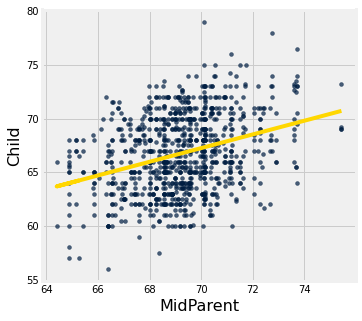

In [ ]:
scatter_fit(heights, 'MidParent', 'Child')

A *residual plot* can be drawn by plotting the residuals against the predictor variable. The function `residual_plot` does just that. 

In [ ]:
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

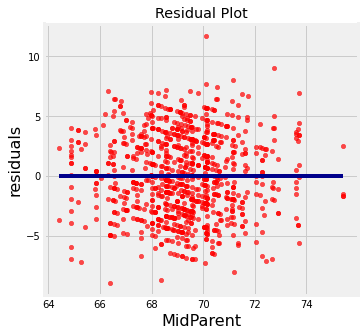

In [ ]:
residual_plot(heights, 'MidParent', 'Child')

The midparent heights are on the horizontal axis, as in the original scatter plot. But now the vertical axis shows the residuals. Notice that the plot appears to be centered around the horizontal line at the level 0 (shown in dark blue). Notice also that the plot shows no upward or downward trend. We will observe later that this lack of trend is true of all regressions.

###15.5.1. Regression Diagnostics
Residual plots help us make visual assessments of the quality of a linear regression analysis. Such assessments are called *diagnostics*. The function ``regression_diagnostic_plots`` draws the original scatter plot as well as the residual plot for ease of comparison.

In [ ]:
def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)

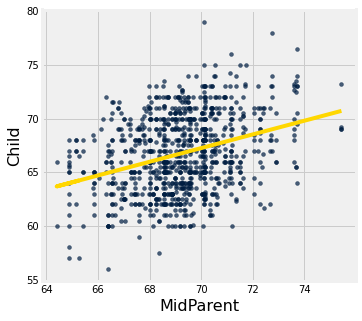

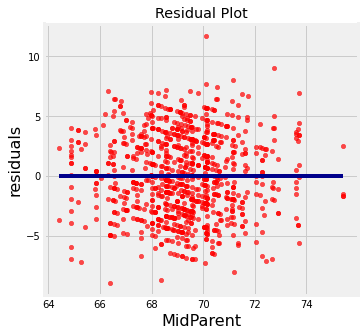

In [ ]:
regression_diagnostic_plots(heights, 'MidParent', 'Child')

This residual plot indicates that linear regression was a reasonable method of estimation. Notice how the residuals are distributed fairly symmetrically above and below the horizontal line at 0, corresponding to the original scatter plot being roughly symmetrical above and below. Notice also that the vertical spread of the plot is fairly even across the most common values of the children's heights. In other words, apart from a few outlying points, the plot isn't narrower in some places and wider in others.

In other words, the accuracy of the regression appears to be about the same across the observed range of the predictor variable. 

**The residual plot of a good regression shows no pattern. The residuals look about the same, above and below the horizontal line at 0, across the range of the predictor variable.**

###15.5.2. Detecting Nonlinearity
Drawing the scatter plot of the data usually gives an indication of whether the relation between the two variables is non-linear. Often, however, it is easier to spot non-linearity in a residual plot than in the original scatter plot. This is usually because of the scales of the two plots: the residual plot allows us to zoom in on the errors and hence makes it easier to spot patterns.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/75/Dugong_dugon.jpg"/>

Our data are a [dataset](http://www.statsci.org/data/oz/dugongs.html)  on the age and length of dugongs, which are marine mammals related to manatees and sea cows (image from [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Dugong_dugon.jpg)). The data are in a table called `dugong`. Age is measured in years and length in meters. Because dugongs tend not to keep track of their birthdays, ages are estimated based on variables such as the condition of their teeth.

In [ ]:
dugong = Table.read_table(path_data + 'dugongs.csv')
dugong = dugong.move_to_start('Length')
dugong

Length,Age
1.8,1
1.85,1.5
1.87,1.5
1.77,1.5
2.02,2.5
2.27,4
2.15,5
2.26,5
2.35,7
2.47,8


####RMSE

In [ ]:
def shotput_quadratic_rmse(a, b, c):
    x = dugong.column('Length')
    y = dugong.column('Age')
    fitted = a*(x**2) + b*x + c
    return math.sqrt(np.mean((y - fitted) ** 2))
#mean of the square of the differences

In [ ]:
best = minimize(shotput_quadratic_mse)
best

array([  5.18562992,   0.95368454, -19.94872713])

In [ ]:
shotput_quadratic_mse(best.item(0), best.item(1), best.item(2))

4.123876954639015

#### remain to the context

If we could measure the length of a dugong, what could we say about its age? Let's examine what our data say. Here is a regression of age (the response) on length (the predictor). The correlation between the two variables is substantial, at 0.83.

In [ ]:
correlation(dugong, 'Length', 'Age')

0.8296474554905714

High correlation notwithstanding, the plot shows a curved pattern that is much more visible in the residual plot.

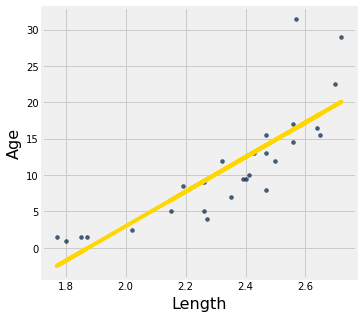

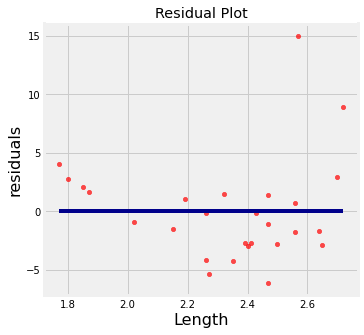

In [ ]:
regression_diagnostic_plots(dugong, 'Length', 'Age')

While you can spot the non-linearity in the original scatter, it is more clearly evident in the residual plot.

At the low end of the lengths, the residuals are almost all positive; then they are almost all negative; then positive again at the high end of lengths. In other words the regression estimates have a pattern of being too high, then too low, then too high. That means it would have been better to use a curve instead of a straight line to estimate the ages.

**When a residual plot shows a pattern, there may be a non-linear relation between the variables.**

###15.5.3. Detecting Heteroscedasticity

*Heteroscedasticity* is a word that will surely be of interest to those who are preparing for Spelling Bees. For data scientists, its interest lies in its meaning, which is "uneven spread". 

Recall the table `hybrid` that contains data on hybrid cars in the U.S. Here is a regression of fuel efficiency on the rate of acceleration. The association is negative: cars that accelearate quickly tend to be less efficient.

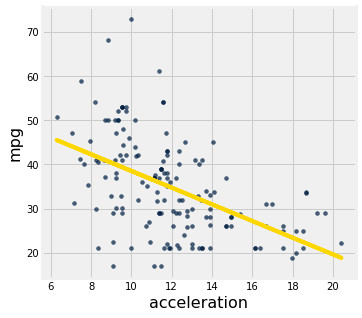

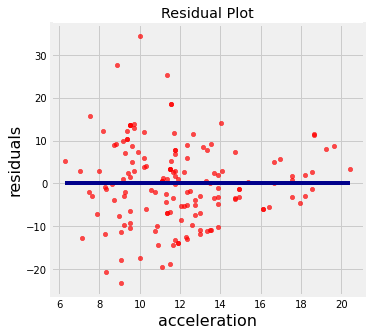

In [ ]:
regression_diagnostic_plots(hybrid, 'acceleration', 'mpg')

Notice how the residual plot flares out towards the low end of the accelerations. In other words, the variability in the size of the errors is greater for low values of acceleration than for high values. Uneven variation is often more easily noticed in a residual plot than in the original scatter plot.

**If the residual plot shows uneven variation about the horizontal line at 0, the regression estimates are not equally accurate across the range of the predictor variable.**

##15.6. Numerical Diagnostics

In addition to visualization, we can use numerical properties of residuals to assess the quality of regression. We will not prove these properties mathematically. Rather, we will observe them by computation and see what they tell us about the regression.

All of the facts listed below hold for all shapes of scatter plots, whether or not they are linear.

In [ ]:
family_heights = Table.read_table(path_data + 'family_heights.csv')
heights = family_heights.select('midparentHeight', 'childHeight')
heights = heights.relabel(0, 'MidParent').relabel(1, 'Child')
dugong = Table.read_table(path_data + 'dugongs.csv')
dugong = dugong.move_to_start('Length')
hybrid = Table.read_table(path_data + 'hybrid.csv')

In [ ]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def correlation(table, x, y):
    x_in_standard_units = standard_units(table.column(x))
    y_in_standard_units = standard_units(table.column(y))
    return np.mean(x_in_standard_units * y_in_standard_units)

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) -  a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)
    
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)   

In [ ]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )

###15.6.1. Residual Plots Show No Trend
**For every linear regression, whether good or bad, the residual plot shows no trend. Overall, it is flat. In other words, the residuals and the predictor variable are uncorrelated.** 

You can see this in all the residual plots above. We can also calculate the correlation between the predictor variable and the residuals in each case.



In [ ]:
correlation(heights, 'MidParent', 'Residual')

-2.719689807647064e-16

That doesn't look like zero, but it is a tiny number that is 0 apart from rounding error due to computation. Here it is again, correct to 10 decimal places. The minus sign is because of the rounding that above.

In [ ]:
round(correlation(heights, 'MidParent', 'Residual'), 10)

-0.0

In [ ]:
dugong = dugong.with_columns(
       'Fitted Value', fit(dugong, 'Length', 'Age'),
       'Residual', residual(dugong, 'Length', 'Age')
)
round(correlation(dugong, 'Length', 'Residual'), 10)

0.0

###15.6.2. Average of Residuals
**No matter what the shape of the scatter diagram, the average of the residuals is 0.**

This is analogous to the fact that if you take any list of numbers and calculate the list of deviations from average, the average of the deviations is 0.

In all the residual plots above, you have seen the horizontal line at 0 going through the center of the plot. That is a visualization of this fact.

As a numerical example, here is the average of the residuals in the regression of children's heights based on midparent heights.

In [ ]:
round(np.mean(heights.column('Residual')), 10)

0.0

The same is true of the average of the residuals in the regression of the age of dugongs on their length. The mean of the residuals is 0, apart from rounding error. 

In [ ]:
round(np.mean(dugong.column('Residual')), 10)

0.0

###15.6.3. SD of the Residuals
**No matter what the shape of the scatter plot, the SD of the residuals is a fraction of the SD of the response variable. The fraction is  $\sqrt{1-r^2}$.**

$$
\mbox{SD of residuals} ~=~ \sqrt{1 - r^2} \cdot \mbox{SD of }y
$$

We will soon see how this measures the accuracy of the regression estimate. But first, let's confirm it by example. 

In the case of children's heights and midparent heights, the SD of the residuals is about 3.39 inches.

In [ ]:
np.std(heights.column('Residual'))

3.3880799163953426

That's the same as $\sqrt{1-r^2}$ times the SD of response variable: 

In [ ]:
r = correlation(heights, 'MidParent', 'Child')
np.sqrt(1 - r**2) * np.std(heights.column('Child'))

3.388079916395342

The same is true for the regression of mileage on acceleration of hybrid cars. The correlation $r$ is negative (about -0.5), but $r^2$ is positive and therefore $\sqrt{1-r^2}$ is a fraction.

In [ ]:
r = correlation(hybrid, 'acceleration', 'mpg')
r

-0.5060703843771186

In [ ]:
hybrid = hybrid.with_columns(
     'fitted mpg', fit(hybrid, 'acceleration', 'mpg'),
     'residual', residual(hybrid, 'acceleration', 'mpg')
)
np.std(hybrid.column('residual')), np.sqrt(1 - r**2)*np.std(hybrid.column('mpg'))

(9.43273683343029, 9.43273683343029)

Now let us see how the SD of the residuals is a measure of how good the regression is. Remember that the average of the residuals is 0. Therefore the smaller the SD of the residuals is, the closer the residuals are to 0. In other words, if the SD of the residuals is small, the overall size of the errors in regression is small.

The extreme cases are when $r=1$ or $r=-1$. In both cases, $\sqrt{1-r^2} = 0$. Therefore the residuals have an average of 0 and an SD of 0 as well, and therefore the residuals are all equal to 0. The regression line does a perfect job of estimation. As we saw earlier in this chapter, if $r = \pm 1$, the scatter plot is a perfect straight line and is the same as the regression line, so indeed there is no error in the regression estimate. 

But usually $r$ is not at the extremes. If $r$ is neither $\pm 1$ nor 0, then $\sqrt{1-r^2}$ is a proper fraction, and the rough overall size of the error of the regression estimate is somewhere between 0 and the SD of $y$.

The worst case is when $r = 0$. Then $\sqrt{1-r^2} =1$, and the SD of the residuals is equal to the SD of $y$. This is consistent with the observation that if $r=0$ then the regression line is a flat line at the average of $y$. In this situation, the root mean square error of regression is the root mean squared deviation from the average of $y$, which is the SD of $y$. In practical terms, if $r = 0$ then there is no linear association between the two variables, so there is no benefit in using linear regression.

###15.6.4. Another Way to Interpret $r$
We can rewrite the result above to say that no matter what the shape of the scatter plot,

$$
\frac{\mbox{SD of residuals}}{\mbox{SD of }y} ~=~ \sqrt{1-r^2}
$$

A complementary result is that no matter what the shape of the scatter plot, the SD of the fitted values is a fraction of the SD of the observed values of $y$. The fraction is $\vert r \vert$.

$$
\frac{\mbox{SD of fitted values}}{\mbox{SD of }y} ~=~ \vert r \vert
$$

To see where the fraction comes in, notice that the fitted values are all on the regression line whereas the observed values of $y$ are the heights of all the points in the scatter plot and are more variable.

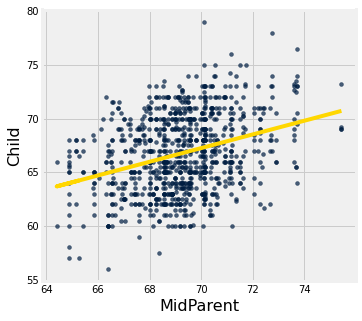

In [ ]:
scatter_fit(heights, 'MidParent', 'Child')

The fitted values range from about 64 to about 71, whereas the heights of all the children are quite a bit more variable, ranging from about 55 to 80.

To verify the result numerically, we just have to calculate both sides of the identity.

In [ ]:
correlation(heights, 'MidParent', 'Child')

0.32094989606395924

Here is ratio of the SD of the fitted values and the SD of the observed values of birth weight:

In [ ]:
np.std(heights.column('Fitted Value'))/np.std(heights.column('Child'))

0.32094989606395957

The ratio is equal to $r$, confirming our result.

Where does the absolute value come in? First note that as SDs can't be negative, nor can a ratio of SDs. So what happens when $r$ is negative? The example of fuel efficiency and acceleration will show us.

In [ ]:
correlation(hybrid, 'acceleration', 'mpg')

-0.5060703843771186

In [ ]:
np.std(hybrid.column('fitted mpg'))/np.std(hybrid.column('mpg'))

0.5060703843771186

The ratio of the two SDs is $\vert r \vert$. 

A more standard way to express this result is to recall that 

$$
\mbox{variance} ~=~ \mbox{mean squared deviation from average} ~=~ \mbox{SD}^2
$$

and therefore, by squaring both sides of our result,

$$
\frac{\mbox{variance of fitted values}}{\mbox{variance of }y} ~=~ r^2
$$